In [1]:
!pip install keras
!pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from random import shuffle
import shutil
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [4]:
class_name = os.listdir('/content/drive/MyDrive/Task - 04/Data')
class_name

['Hello', 'candy', 'who', 'No', 'I love you', 'Yes', 'C', 'B', 'A']

In [5]:
class_name_labels = {class_name:i for i , class_name in enumerate(class_name)}

nb_classes = len(class_name)

print(class_name_labels)

img_size = (224,224)

{'Hello': 0, 'candy': 1, 'who': 2, 'No': 3, 'I love you': 4, 'Yes': 5, 'C': 6, 'B': 7, 'A': 8}


In [6]:
def load_data():
    DIRECTORY = '/content/drive/MyDrive/Task - 04/Data1'
    CATEGORY = ["train", "test"]
    output = []

    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)

        if not os.path.exists(path):
            print(f"Warning: {path} does not exist.")
            continue

        images = []
        labels = []

        print("Loading {}".format(category))

        for folder in os.listdir(path):
            label = class_name_labels.get(folder, -1)

            if label == -1:
                print(f"Warning: Label not found for folder {folder}. Skipping.")
                continue

            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)

                try:
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, img_size)

                    # Normalize pixel values to be between 0 and 1
                    image = image / 255.0

                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {str(e)}")

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        # Shuffle the data
        indices = np.arange(images.shape[0])
        np.random.shuffle(indices)

        images = images[indices]
        labels = labels[indices]

        # Data augmentation using Keras
        if category == "train":
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            augmented_images = []
            augmented_labels = []

            for i in range(images.shape[0]):
                img = np.expand_dims(images[i], axis=0)
                datagen.fit(img)
                augmented_batch = datagen.flow(img, batch_size=1)

                augmented_images.append(augmented_batch[0][0])
                augmented_labels.append(labels[i])

            augmented_images = np.array(augmented_images)
            augmented_labels = np.array(augmented_labels)

            images = np.concatenate((images, augmented_images), axis=0)
            labels = np.concatenate((labels, augmented_labels), axis=0)

        output.append((images, labels))

    return output

In [7]:
(train_images , train_labels) , (test_images, test_labels) = load_data()

Loading train
Loading test


In [8]:
from sklearn.utils import shuffle
from keras import layers, models

In [9]:
train_images, train_labels = shuffle(train_images,train_labels, random_state=25)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(9, activation=tf.nn.softmax)
])

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
34/34 [==============================] - 24s 368ms/step - loss: 1.4702 - accuracy: 0.5767 - val_loss: 0.4079 - val_accuracy: 0.8550
Epoch 2/6
34/34 [==============================] - 7s 208ms/step - loss: 0.3337 - accuracy: 0.8842 - val_loss: 0.2208 - val_accuracy: 0.9266
Epoch 3/6
34/34 [==============================] - 7s 198ms/step - loss: 0.1560 - accuracy: 0.9472 - val_loss: 0.1778 - val_accuracy: 0.9275
Epoch 4/6
34/34 [==============================] - 7s 216ms/step - loss: 0.0793 - accuracy: 0.9749 - val_loss: 0.1931 - val_accuracy: 0.9322
Epoch 5/6
34/34 [==============================] - 8s 230ms/step - loss: 0.0685 - accuracy: 0.9772 - val_loss: 0.1045 - val_accuracy: 0.9638
Epoch 6/6
34/34 [==============================] - 7s 210ms/step - loss: 0.0511 - accuracy: 0.9823 - val_loss: 0.1930 - val_accuracy: 0.9359


In [14]:
model.save("/content/drive/MyDrive/Task - 04/hand.h5")

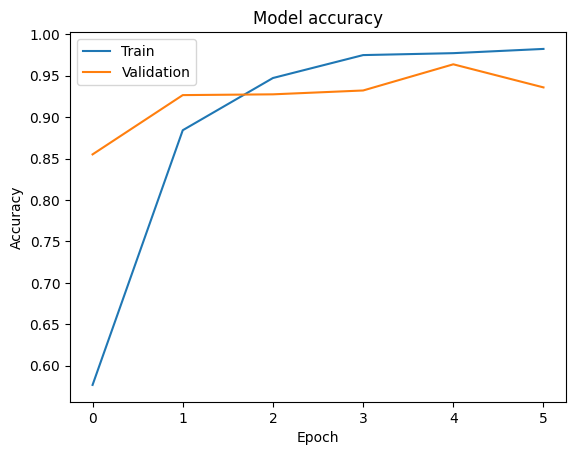

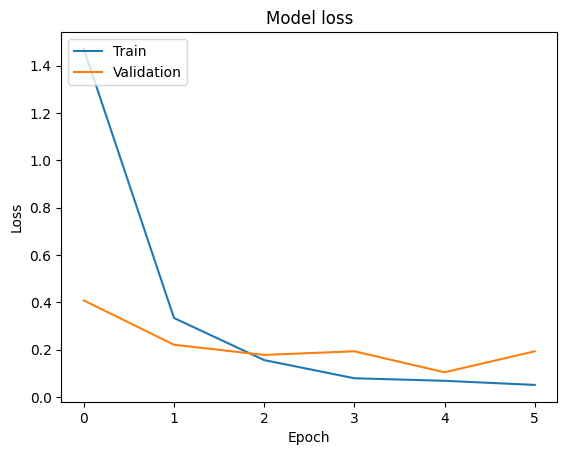

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
